In [ ]:
!pip install yfinance
!pip install pandas numpy matplotlib scipy


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [ ]:
# Define the list of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

# Download historical data for the tickers
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Adj Close']

# Display the first few rows of the data
data.head()


[*********************100%%**********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2020-01-02,72.960464,94.900497,68.355545,209.349792,154.215668
2020-01-03,72.251152,93.748497,67.997955,208.242081,152.295395
2020-01-06,72.826851,95.143997,69.810379,212.164032,152.689072
2020-01-07,72.484352,95.343002,69.675537,212.623077,151.296906
2020-01-08,73.650345,94.598503,70.171463,214.778656,153.706787


In [ ]:
# Calculate daily returns, filling NA values to avoid future warnings
returns = data.pct_change(fill_method='ffill').dropna()

# Check if the returns DataFrame is empty
if returns.empty:
    raise ValueError("No returns data available. Please check the tickers and date range.")

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Display the first few rows of the returns
returns.head()


<ipython-input-23-7796c260c256>:2: FutureWarning: The 'fill_method' keyword being not None and the 'limit' keyword in DataFrame.pct_change are deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change(fill_method='ffill').dropna()


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2020-01-03,-0.009722,-0.012139,-0.005231,-0.005291,-0.012452
2020-01-06,0.007968,0.014886,0.026654,0.018834,0.002585
2020-01-07,-0.004703,0.002092,-0.001932,0.002164,-0.009118
2020-01-08,0.016086,-0.007809,0.007118,0.010138,0.015928
2020-01-09,0.021241,0.004799,0.010498,0.014311,0.012493


In [ ]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    return returns, std

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_returns - risk_free_rate) / p_std

def get_portfolio_vol(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Number of assets in the portfolio
num_assets = len(tickers)

# Constraints: sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess: equal distribution
init_guess = num_assets * [1. / num_assets]

# Optimize portfolio
opts = minimize(negative_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix),
                method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = opts.x

# Display optimal weights
print("Optimal Weights:", optimal_weights)

# Calculate performance of the optimized portfolio
opt_returns, opt_std = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

# Display the optimized portfolio performance
print(f"Expected Annual Return: {opt_returns:.2f}")
print(f"Annual Volatility (Standard Deviation): {opt_std:.2f}")


Optimal Weights: [6.02206257e-01 0.00000000e+00 4.79217360e-17 0.00000000e+00
 3.97793743e-01]
Expected Annual Return: 0.29
Annual Volatility (Standard Deviation): 0.31


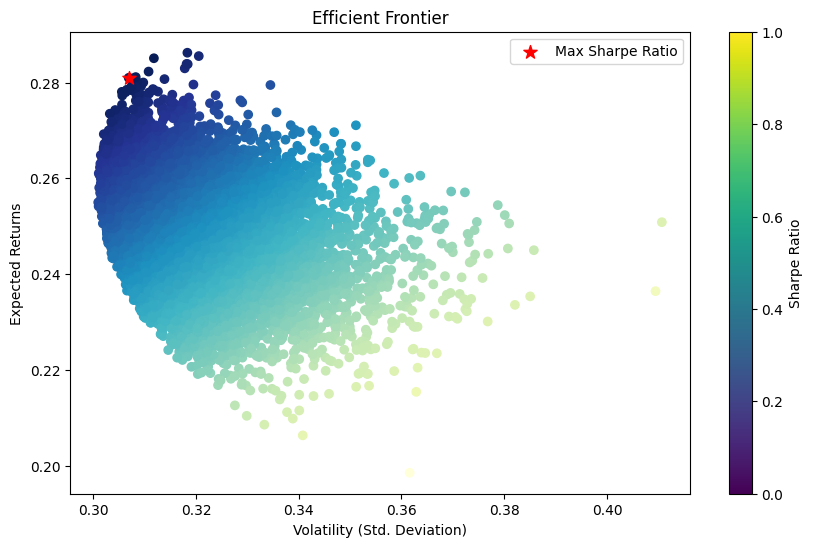

In [ ]:
# Plot the efficient frontier
def plot_efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_stddev = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_stddev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_stddev

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = weights_record[max_sharpe_idx]

    plt.figure(figsize=(10, 6))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
    plt.scatter(sdp, rp, marker='*', color='r', s=100, label='Max Sharpe Ratio')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.colorbar(label='Sharpe Ratio')
    plt.legend(labelspacing=0.8)
    plt.show()

plot_efficient_frontier(mean_returns, cov_matrix)
